# Pyspark TensorFlow Inference

## Text classification
Based on: https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses

In [2]:
print(tf.__version__)

2.8.0


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

In [4]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'train', 'test', 'README']

In [5]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'unsupBow.feat',
 'unsup',
 'urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'pos']

In [6]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-08-16 10:30:11.890359: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 7ms/step - loss: 0.6665 - binary_accuracy: 0.6892 - val_loss: 0.6177 - val_binary_accuracy: 0.7666
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5506 - binary_accuracy: 0.7988 - val_loss: 0.4996 - val_binary_accuracy: 0.8216
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4464 - binary_accuracy: 0.8433 - val_loss: 0.4212 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3795 - binary_accuracy: 0.8651 - val_loss: 0.3745 - val_binary_accuracy: 0.8600
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3367 - binary_accuracy: 0.8778 - val_loss: 0.3457 - val_binary_accuracy: 0.8664
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3061 - binary_accuracy: 0.8885 - val_loss: 0.3266 - val_binary_accuracy: 0.8702
Epoch 7/10
625/625 [==============================] - 4s 6ms/ste

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.3107 - binary_accuracy: 0.8724
Loss:  0.3107016980648041
Accuracy:  0.8723999857902527


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

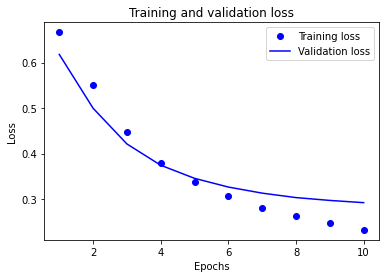

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

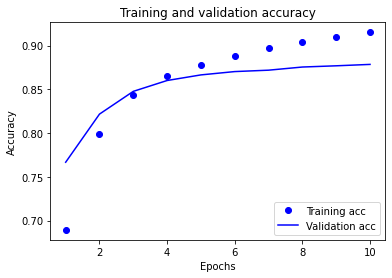

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3107 - accuracy: 0.8724
0.8723999857902527


In [30]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.61419255],
       [0.4353525 ],
       [0.35193822]], dtype=float32)

### Save Model

In [31]:
!rm -rf text_model

In [32]:
export_model.save('text_model')

2022-08-16 10:31:05.536986: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: text_model/assets


### Inspect saved model

In [33]:
!tree text_model

text_model
├── assets
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 4 files


In [34]:
!saved_model_cli show --dir text_model --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['text_vectorization_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text_vectorization_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['activation'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall_1:0
Method name is: tensorflow/serving/predict


### Load model

In [35]:
# register callables as custom objects before loading
custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('text_model')

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Predict

In [36]:
new_model.predict(examples)

array([[0.61419255],
       [0.4353525 ],
       [0.35193822]], dtype=float32)

## PySpark

## Inference using Spark ML Model
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import re
import sparkext.tensorflow
import string
import tensorflow as tf

from pathlib import Path
from tensorflow.keras import layers

In [38]:
# note: using huggingface IMDB parquet for now, since conversion above isn't working
dataset = Path("../huggingface/imdb_test").absolute().as_posix()
df = spark.read.parquet(dataset).repartition(10)

In [39]:
df.show(truncate=120)

+------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                   lines|
+------------------------------------------------------------------------------------------------------------------------+
|New Year's Day. The day after consuming a few too many vodka martinis and Cosmopolitans mixed with a bunch of bubbly ...|
|For those with access to the BBC or the CBC, this has proved to be spectacular. Like Battlestar Gallactica, this is a...|
|Produced by Nott Entertainment, this movie is "nott" very good at all. I sat through the first 15 minutes of the film...|
|To be fair, I didn't see a lot of this show. Probably because it wasn't as good as the original M*A*S*H, but I seem t...|
|Because it came from HBO and based on the IMDb rating, I watched the first season of this series, what a waste. The c...|
|Just saw this m

In [40]:
def model_loader(path: str):
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers
    
    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )
    
    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )
    
    custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(path)

    return model

In [41]:
# Note: must use absolute path to model, since executors have their own current working directories
model_path = Path("text_model").absolute().as_posix()
print(f"model: {model_path}")

model = sparkext.tensorflow.Model(model_path, model_loader) \
                .setInputCol("lines") \
                .setOutputCol("preds")

model: /home/leey/devpub/leewyang/sparkext/examples/tensorflow/text_model


In [42]:
predictions = model.transform(df)

Deferring model loading to executors.
ModelSummary(num_params=160033, inputs=[TensorSummary(dtype=dtype('<U'), shape=[-1], name='text_vectorization_input')], outputs=[TensorSummary(dtype=dtype('float32'), shape=[-1, 1], name='activation/Sigmoid:0')]) -> array<float>


In [43]:
%%time
preds = predictions.collect()

CPU times: user 129 ms, sys: 28 ms, total: 157 ms
Wall time: 5.59 s


In [44]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+--------------+
|                                                                           lines|         preds|
+--------------------------------------------------------------------------------+--------------+
|New Year's Day. The day after consuming a few too many vodka martinis and Cos...|  [0.33847392]|
|For those with access to the BBC or the CBC, this has proved to be spectacula...|   [0.4092393]|
|Produced by Nott Entertainment, this movie is "nott" very good at all. I sat ...|  [0.03726065]|
|To be fair, I didn't see a lot of this show. Probably because it wasn't as go...|[0.0027081966]|
|Because it came from HBO and based on the IMDb rating, I watched the first se...|  [0.20558989]|
|Just saw this movie on opening night. I read some other user comments which c...|  [0.08418906]|
|This movie is very well done although the ending is given away too early in t...|    [0.865628]|
|Gilmore Girls is my

## Inference using Spark DL UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [45]:
from pyspark.sql.functions import struct
from sparkext.tensorflow import model_udf
from pathlib import Path

In [46]:
# note: using huggingface IMDB parquet for now, since conversion above isn't working
dataset = Path("../huggingface/imdb_test").absolute().as_posix()
df = spark.read.parquet(dataset).repartition(10)

In [47]:
df.show(truncate=120)

+------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                   lines|
+------------------------------------------------------------------------------------------------------------------------+
|New Year's Day. The day after consuming a few too many vodka martinis and Cosmopolitans mixed with a bunch of bubbly ...|
|For those with access to the BBC or the CBC, this has proved to be spectacular. Like Battlestar Gallactica, this is a...|
|Produced by Nott Entertainment, this movie is "nott" very good at all. I sat through the first 15 minutes of the film...|
|To be fair, I didn't see a lot of this show. Probably because it wasn't as good as the original M*A*S*H, but I seem t...|
|Because it came from HBO and based on the IMDb rating, I watched the first season of this series, what a waste. The c...|
|Just saw this m

In [48]:
def model_loader(path: str):
    # since this function runs on the executor, any required imports should be added inside the function.
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers
    
    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )
    
    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )
    
    custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(path)

    return model

In [49]:
# get absolute path to model, since executors have their own current working directories
model_path = Path("text_model").absolute().as_posix()

In [50]:
classify = model_udf(model_path, model_loader)

Deferring model loading to executors.
ModelSummary(num_params=160033, inputs=[TensorSummary(dtype=dtype('<U'), shape=[-1], name='text_vectorization_input')], outputs=[TensorSummary(dtype=dtype('float32'), shape=[-1, 1], name='activation/Sigmoid:0')]) -> array<float>


In [51]:
predictions = df.withColumn("preds", classify(struct("lines")))

In [52]:
%%time
results = predictions.collect()

CPU times: user 150 ms, sys: 25.5 ms, total: 176 ms
Wall time: 3.7 s


In [53]:
predictions.show(truncate=80)

+--------------------------------------------------------------------------------+-------------+
|                                                                           lines|        preds|
+--------------------------------------------------------------------------------+-------------+
|Lucille Ball cannot sing or act or dance. This makes the quality of her perfo...|[0.028360933]|
|Wretched. Talk about botched. BEYOND THE POSEIDON ADVENTURE is bad in every r...|[0.087665826]|
|Here's what you have to remember about this movie.... IT'S A KIDS MOVIE!!!!! ...| [0.38986945]|
|This picture is an interesting saga of the struggle of pioneers led by Daniel...|  [0.6452766]|
|Steamboat Willy was not the first cartoon to feature Mickey Mouse. The first ...| [0.79516363]|
|This movie shows me, that americans have no knowledge about the situation in ...|  [0.5702114]|
|I had looked forward to viewing this movie, it seemed anyone who had seen it ...|[0.035621643]|
|Way back in 1996, One of the 